# Keras Time-Series Anomaly Detection
***



[1]: https://stats.stackexchange.com/questions/262044/what-does-a-bottleneck-layer-mean-in-neural-networks



[2]: https://www.baeldung.com/cs/dl-latent-space#:~:text=Definition,other%20in%20the%20latent%20space.

This notebook demonstrates how a reconstruction convolutional autoencoder model can be used to detect anomalies in timeseries data.


An AutoEncoder model is a generative unsupervised deep learning algorithm used for reconstructing high-dimensional input data (or data which has more features than observations), using a neural network with a narrow bottleneck layer in the middle which contains the latent representation of the input data.

![](https://www.statology.org/wp-content/uploads/2021/02/highDim1-768x200.png)

A narrow bottleneck layer means that the layer has fewer nodes, and this can be used to obtain a representation of the input with reduced dimensionality. [1]

An Autoencoder consists of an Encoder and a Decoder.

## Encoder network: 
Accepts high-dimensional input data and translates it to latent low-dimensional data (data which has more observations than features). An example of low dimensional data would be the well-known Fishers' iris dataset which has a lot of observations compared to features.  The input size to an Encoder network is larger than its output size.

## Decoder network:
The Decoder network receives the input from the Encoder coder’s output, and its objective is to reconstruct the input data. The output size of a Decoder network is larger than its input size.

So, the Autoencoder accepts high-dimensional input data, compresses it down to the latent-space representation in the bottleneck hidden layer; the Decoder takes the latent representation of the data as an input to reconstruct the original input data.

### Latent Space 
Formally, a latent space is defined as an abstract multi-dimensional space that encodes a meaningful internal representation of externally observed events. [2]  As humans we perceive the world by keeping an internal representation of the general appearance of objects as a compressed representation in our brain. Similarly, the latent space in deep learning tries to provide a compressed understanding of the world to a computer through a spatial representation. Its main goal is to transform the raw data (such as the pixel values of an image) into a suitable internal representation from which the learning subsystem, often a classifier, could detect or classify patterns in the input. Deep learning and latent space are strongly related concepts since the internal representations of the former constitute the latter.

A deep learning model takes as input raw data and outputs discriminative features that lie in a low-dimensional space referred to as latent space. These features are then used to solve various tasks like classification, regression, or reconstruction. Latent space is used for data compression particularly in cases where input data is high-dimensional, as it is impossible to learn important information directly from the raw data by looking at so many values. The solution therefore is to encode the high-dimensional input space to a low-dimensional latent space using a deep neural network.


### Anomaly detection using Autoencoders: 

During training, normal transactions are inputted to the Encoder. The bottleneck layer will learn the latent representation of the normal input data.
The Decoder will then use the bottleneck layers output to reconstruct the normal transactions of the original input data.

This image offers a good representation of a simplified version of the neural network we will be using: 

![](images/NEURALNETWORK.png)


In [1]:
# Importing required libraries including Keras

import pandas as pd
import matplotlib.pyplot as plt
import  numpy as np 
import tensorflow.keras as keras
from tensorflow.keras import layers


2023-01-07 21:01:08.584384: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-07 21:01:08.768405: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-07 21:01:08.768503: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-07 21:01:09.589708: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Numenta Anomaly Benchmark (NAB)

In the Keras Time-Series Anomaly Detection example on the Keras website the user uses the *Numenta Anomaly Benchmark (NAB)* dataset. 

NAB is a novel benchmark for evaluating algorithms for anomaly detection in streaming, real-time applications. The data is ordered, timestamped, single-valued metrics comprised of over 50 real-world and artifical timeseries data containing labeled anomalous periods of behavior. [1] The majority of the data is real-world from a variety of sources such as AWS server metrics, Twitter volume, advertisement clicking metrics, traffic data, and more.


Firstly, in order to get the data from the NAB dataset we must pull it from its GitHub repository using the methods below: 

[1]: https://github.com/numenta/NAB

In [2]:

# Root of URLs.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'


### Preparing the no-anomaly (training) dataset

In [3]:
# Create the non-anomaly data set using Pandas 'read_csv()' function
no_anomaly = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

# Print the first 5 rows to ensure that the data is importing correctly
print(no_anomaly.head())


                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120


In [4]:
# Describe the dataframe
no_anomaly.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


The ```describe``` function returns the mean, max and standard deviation among other variables. 

We will then plot the data to get an overall view of the dataset. 

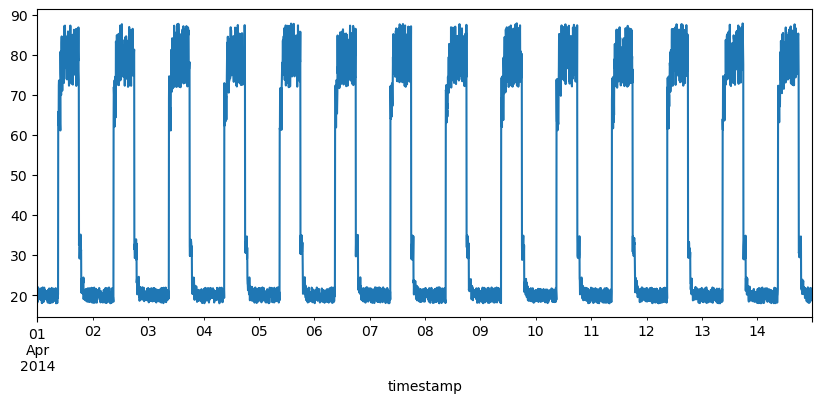

In [5]:
# Set the figsize for the dataset 
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
no_anomaly.plot(legend=False, ax=ax);

### Preparing the anomaly (testing) dataset

In [6]:
# Getting the anomaly dataset 
with_anomaly= pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [7]:
# print first few rows to ensure that the data is imported correctly
print(with_anomaly.head())

                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


In [8]:
# Using the describe() function to get the mean, std,& min and max of the anomaly dataset
with_anomaly.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


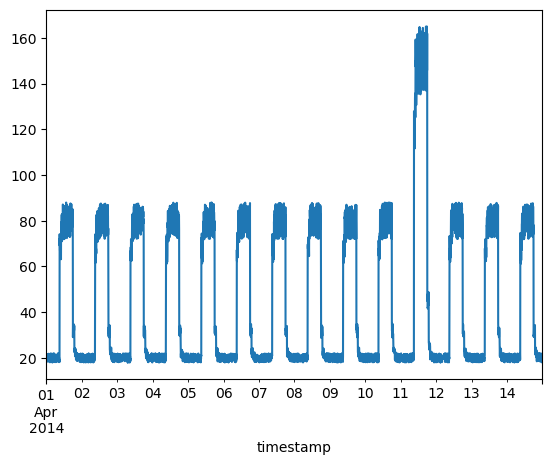

In [9]:
# Create a plot to show the data
fig, ax = plt.subplots()
with_anomaly.plot(legend=False, ax=ax)
plt.show()

We can see that the data has a large anomaly at the 11/12 April timestamp, compared to the non-anomaly dataset

# Training Data 
***


Training data (or a training dataset) is the initial data used to train machine learning models. Training datasets are fed to machine learning algorithms to teach them how to make predictions or perform a desired task. High-quality training data is extremely important, as without this even the most efficient ML algorithms will fail to perform. Only if the algorithm is fed with good training data can it easily pick up the features and find relationships that it needs to predict down the line. Training data builds the machine learning model and teaches what the expected output looks like. The model analyzes the dataset repeatedly to deeply understand its characteristics and adjust itself for better performance.<br>
There are three factors that affect the training data and the quality:

- People: The people who train the model have a significant impact on its accuracy or performance. If they are biased, it will naturally affect how they tag data and, ultimately, how the ML model functions.

- Processes: The data labeling process must have tight quality control checks in place. This will significantly increase the quality of training data.

- Tools: Incompatible or outdated tools can make data quality suffer. Using robust data labeling software can reduce the cost and time associated with the process.

The amount of training data/ data points required will vary depending on the algorithm used.

For context, deep learning, a subset of machine learning, requires millions of data points to train the artificial neural networks (ANNs). In contrast, machine learning algorithms require only thousands of data points. The more you train the model, the more accurate it becomes. So, it is always better to have a large amount of data as training data. <br>
The phrase "garbage in, garbage out" is one of the oldest and most used phrases in data science. Even with the rate of data generation growing exponentially, it still holds true. The key is to feed high-quality, representative data to machine learning algorithms. Doing so can significantly enhance the accuracy of models. Good quality training data is also crucial for creating unbiased machine learning applications. [1]


## Creating some training data

[1]: https://learn.g2.com/training-data 

In [10]:

# Getting the mean of the no anomaly dataset
training_mean = no_anomaly.mean()


In [11]:
# Getting the standard deviation of the no anomaly dataset
training_std = no_anomaly.std()

In [12]:
## Creating the training dataset
# This is done by subracting the mean from the value of each of the points
# Then dividing that by the standard deviation

df_training_value = (no_anomaly - training_mean) / training_std

# Checking the data 
df_training_value.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [47]:
# Standardizing the dataset using the 2 methods below:

# getting the value of each datapoint minus the mean
no_anomaly['less_mean'] = no_anomaly['value'] - no_anomaly['value'].mean()
# Get the value of each datapoint as 'less_mean' divided by the standard deviation
no_anomaly['div_std'] = no_anomaly['less_mean'] / no_anomaly['value'].std()

In [14]:
# Return the dataset with these datapoints included
no_anomaly

,value,less_mean,div_std
timestamp,,,
2014-04-01 00:00:00,18.324919,-24.113435,-0.858829
2014-04-01 00:05:00,21.970327,-20.468026,-0.728993
2014-04-01 00:10:00,18.624806,-23.813547,-0.848148
2014-04-01 00:15:00,21.953684,-20.484669,-0.729586
2014-04-01 00:20:00,21.909120,-20.529234,-0.731173
...,...,...,...
2014-04-14 23:35:00,20.211195,-22.227159,-0.791647
2014-04-14 23:40:00,20.531041,-21.907313,-0.780255
2014-04-14 23:45:00,19.032127,-23.406226,-0.833640


In [15]:
# Printing the mean of the 3 columns in the standardized data
# These are: the mean of the data; the mean of the datapoints minus the mean; and the mean of the 'div_std'

no_anomaly['value'].mean(), no_anomaly['less_mean'].mean(), no_anomaly['div_std'].mean()

(42.438353335806646, -7.342627387941552e-14, -2.616541242931684e-15)

In [16]:
# Printing the standard deviation of the 3 columns in the standardized data 
# The standard deviation of the data; Standard deviation of the datapoints minus the mean; & the standard deviation of the 'div_std'
no_anomaly['value'].std(), no_anomaly['less_mean'].std(), no_anomaly['div_std'].std()

(28.077122281262515, 28.077122281262508, 1.0000000000000018)

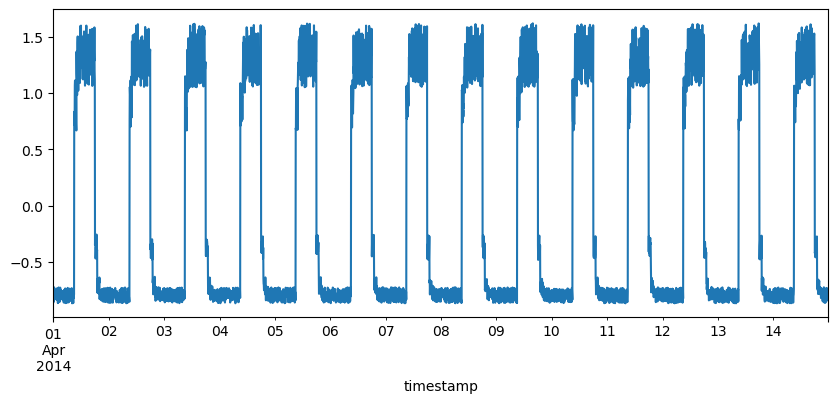

In [17]:
# setting the plot parameters
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot a training value data frame.
df_training_value.plot(legend=False, ax=ax);

## Windowing 

A time series problem is converted into a machine learning problem using windowing. This allows the use of tools and techniques to train and optimize models. To window means to take a dataset and partition it into subsections (which increases the dimension shape of the dataset). In traditional machine learning, more input data tends to be better. It is important to determine all relevant settings like window size, step size and horizon. Generating the horizon is especially important because it represents our known, forecast value - for example, your measurement of the next day or time step - which we can use to train a model. 
This value is usually called the label or target in machine learning. [1]

[1]: https://academy.rapidminer.com/learn/video/using-windowing-on-time-series-data 


### Window Example

In [18]:
# Setting window size
window_size = 288

In [48]:
# Window example.
L = [1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
# Example window size.
win_size = 3
# Length of L
len(L)
# Remove brackets.
len(L) - win_size + 1

# Print the sample windows.
#for i in range(len(L) - win_size + 1):
    #print(L[i:i + win_size])
    
# Create the example windows
wins = []

# Generate the example windows
for i in range(len(L) - win_size + 1):
    wins.append(L[i:i + win_size])
    
# https://numpy.org/doc/stable/reference/generated/numpy.stack.html
# np.stack joins a sequence of arrays along a new axis   
np.stack(wins)


array([[1, 1, 2],
       [1, 2, 4],
       [2, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 1],
       [7, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

### Windowing the Keras dataset

In [20]:
# Creating the Keras dataset 
def windows(vals, N=window_size):
  # create an empty array
  L = []
  # generate the windows
  for i in range(len(vals) - N + 1):
    L.append(vals[i:i+N])
  # Join the sequence arrays along a new axis
  return np.stack(L)

In [21]:
# Adding the training data to the window
x_train = windows(df_training_value)
# checking the first and last datapoints
# These match the values obtained earlier in our dataset
x_train[0][0], x_train[-1][-1]

(array([-0.85882857]), array([-0.8460886]))

In [22]:
df_training_value['value'].values

# Returns a copy of given data collapsed into one dimension
# https://www.w3resource.com/numpy/manipulation/ndarray-flatten.php
x_train[0].flatten()

array([-0.85882857, -0.72899302, -0.84814772, -0.72958579, -0.731173  ,
       -0.75730984, -0.77645641, -0.7880838 , -0.747012  , -0.829166  ,
       -0.80377285, -0.7821597 , -0.81182078, -0.80949918, -0.82334701,
       -0.79001779, -0.74922405, -0.84169024, -0.73727717, -0.77223023,
       -0.75311352, -0.79116337, -0.75934728, -0.86809294, -0.75381057,
       -0.86468256, -0.74361965, -0.72908121, -0.82850668, -0.84043795,
       -0.76136364, -0.8343536 , -0.74708881, -0.85574949, -0.85245676,
       -0.73090636, -0.77440264, -0.74974936, -0.82419543, -0.77402585,
       -0.78574242, -0.7844733 , -0.77316412, -0.78843253, -0.80927467,
       -0.83109167, -0.76090519, -0.83816509, -0.77176485, -0.83715923,
       -0.78131343, -0.76396862, -0.83924191, -0.86186112, -0.85174179,
       -0.78406773, -0.74938477, -0.86399047, -0.76581026, -0.82177506,
       -0.80222751, -0.73807119, -0.82310669, -0.80410682, -0.86845167,
       -0.85877599, -0.83356075, -0.86643297, -0.78045221, -0.80

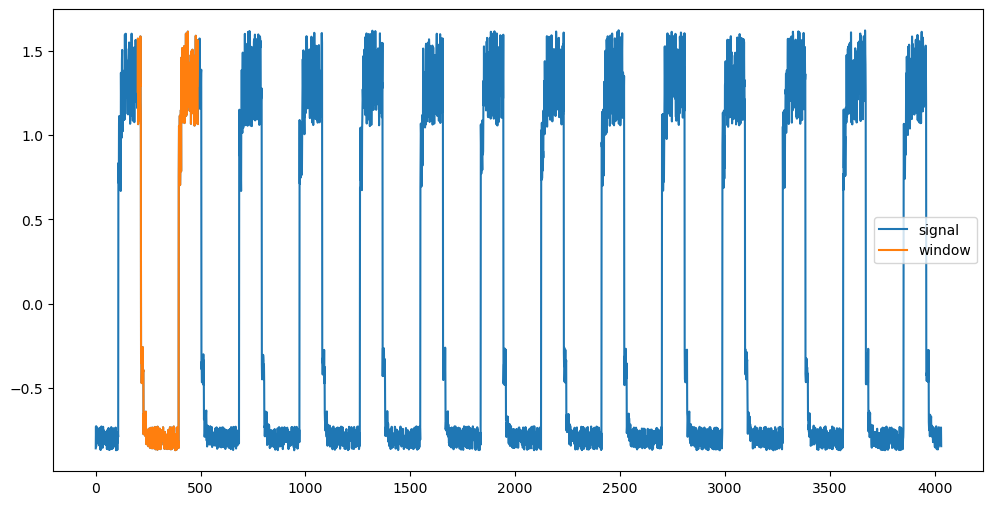

In [23]:
# Selecting a random window to check it's working correctly
# This can be modified- see how the different value effects the plot returned
window_no = 200

# Creating the plot parameters
fig, ax = plt.subplots(figsize=(12, 6))

# setting the y values using the original datapoints
y = df_training_value['value'].values

# plotting the data from the original dataset
ax.plot(np.arange(y.shape[0]), y, label='signal')

# Using the training data as one dimension
w = x_train[window_no].flatten()

# plotting the data from the training data 
ax.plot(np.arange(w.shape[0]) + window_no, w, label='window')

# Setting a legend for the plot
ax.legend();

In [24]:
# Setting time steps with the same quantity as the windows set previously
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

# Set the training data 
x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


# Creating the Model 


Firstly, we want to create the layers that are needed for the model. The layers required are detailed below:

### keras.layers.Input 

Sets the input layer taking the data from the x_train data. In Keras, the input layer passes information and data to the model. Although the keras layer is the input point of the model. it is not a true layer, as there is a hidden layer between this and the next tensor layer through which the data passes to get to the model. [4]

[4]: https://www.educba.com/keras-input/

### keras.layers.Conv1D

1D convolution layer (e.g. temporal convolution). A convolution is an integral that expresses the amount of overlap of one function *g* as it is shifted over another function *f*. It therefore "blends" one function with another.[1] This layer creates a convolution kernel that is convolved with the layer input over a single spatial dimension to produce a tensor of outputs.[1]
 Some of the arguments used in this model are: 

- **filters:** Set the dimensionality of the output space (i.e. the number of output filters in the convolution). Basically, the mean of dimensionality of the output space can be translated to the number of output nodes.

- **kernel_size:** An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.

- **strides:** An integer or tuple/list of a single integer, specifying the stride length of the convolution. The stride length of a convolution defines how many steps we take when sliding our window (filter) across a dataset. A standard convolution has a stride length of one, moving the filter one unit as we scan across the input.

- **padding:** ```same``` results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input.

- **activation:** which activation function is to be used. If activation is not None, it is applied to the outputs as well. In this instance this is the Rectified Linear Unit (ReLU) activation function. [2] The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance. [3]

[1]: https://mathworld.wolfram.com/Convolution.html

[2]: https://keras.io/api/layers/activation_layers/relu/

[3]: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/




### keras.layers.Dropout

The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Overfitting can cause the machine learning model to learn the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. [6] This means that the noise or random fluctuations in the training data is picked up and learned as concepts by the model.  Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.[5]


[5]: https://keras.io/api/layers/regularization_layers/dropout/
[6]: https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/


### keras.layers.Conv1DTranspose

A convolution is an integral that expresses the amount of overlap of one function *g* as it is shifted over another function *f*. Where the conv1d layer blended functions together, the Transpose layer, sometimes called the deconvolution layer, aims to do the opposite and looks to separate the input layer back out. [7]



[7]: https://en.wikipedia.org/wiki/Deconvolution


In [25]:
# Creating the layers of the model
layers = [
  # input layer
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  # first convolution layer
  keras.layers.Conv1D(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  # removing some input values so that overfitting does not occur
  keras.layers.Dropout(rate=0.2),
  # This is  the bottleneck layer 
  keras.layers.Conv1D(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  # First deconvolution layer
  keras.layers.Conv1DTranspose(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  # removing some values so overfitting does not occur
  keras.layers.Dropout(rate=0.2),
  # Second output layer
  keras.layers.Conv1DTranspose(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Final deconvolution layer- this is the output layer 
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]


### Sequential modelling

 Sequential models are built by adding layers to it one by one. By adding layers, we can make a stack of layers which will be interconnected and can be used.[1] A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. [2]

[1]: https://www.projectpro.io/recipes/what-is-sequential-modelling-keras
[2]: https://keras.io/guides/sequential_model/

In [26]:
# Sequential groups a linear stack of layers into a tf.keras.Model.
model = keras.Sequential(layers)


2023-01-07 21:01:14.217068: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-07 21:01:14.217162: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-07 21:01:14.217245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (penguin): /proc/driver/nvidia/version does not exist
2023-01-07 21:01:14.217562: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Optimization

Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training. A learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds. It can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.
Adam is different to classical stochastic gradient descent. Some of the benefits of using this method include it being: Straightforward to implement, computationally efficient with little memory requirements and is well suited for large data problems.

One of the arguments in this function is ```learning_rate``` or step size. This is the proportion that weights are updated (e.g. 0.001). Larger values (e.g. 0.3) results in faster initial learning before the rate is updated. Smaller values (e.g. 1.0E-5) slows learning right down during training

In [27]:
# set the optimizer values
optimizer = keras.optimizers.Adam(learning_rate=0.001)


### Cost/ Loss function 

[1]: https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3
[2]: https://www.analyticsvidhya.com/blog/2022/06/understanding-loss-function-in-deep-learning/

In simple terms, the Loss function is a method of evaluating how well your algorithm is modeling your dataset. It is a mathematical function of the parameters of the machine learning algorithm.[2]
The Mean Squared Error (MSE) is perhaps the simplest and most common loss function. To calculate the MSE, you take the difference between your model’s predictions and the ground truth, square it, and average it out across the whole dataset.[1]


In [28]:
# Compile the model using the optimizer and the loss function
model.compile(optimizer=optimizer, loss="mse")


In [29]:
# Returns a summary of the model being used 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

## model.fit()


model.fit() fits training data and trains the model for a fixed number of epochs (iterations on a dataset). It takes in arguments such as ```input data```, ```batch size``` (Number of samples per gradient update), ```Epoch``` (the number of times the data is iterated over), ```validation_split``` (Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. The validation data is selected from the last samples in the x and y data provided, before shuffling) and ```callbacks``` (Stop training when a monitored metric has stopped improving.). [1]

```EarlyStopping``` monitors the validation loss,  ```patience``` is the number of epochs with no improvement after which training will be stopped, in this instance set as 5; and in ```min``` mode, training will stop when the quantity monitored has stopped decreasing. [2]

[1]: https://keras.io/api/models/model_training_apis/ 

[2]: https://keras.io/api/callbacks/early_stopping/ 

  

In [30]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)


Epoch 1/50
27/27 [==============================] - 3s 75ms/step - loss: 0.5125 - val_loss: 0.0650
Epoch 2/50
27/27 [==============================] - 2s 63ms/step - loss: 0.0808 - val_loss: 0.0460
Epoch 3/50
27/27 [==============================] - 2s 67ms/step - loss: 0.0599 - val_loss: 0.0381
Epoch 4/50
27/27 [==============================] - 2s 65ms/step - loss: 0.0503 - val_loss: 0.0316
Epoch 5/50
27/27 [==============================] - 2s 63ms/step - loss: 0.0428 - val_loss: 0.0272
Epoch 6/50
27/27 [==============================] - 2s 59ms/step - loss: 0.0374 - val_loss: 0.0250
Epoch 7/50
27/27 [==============================] - 2s 66ms/step - loss: 0.0334 - val_loss: 0.0230
Epoch 8/50
27/27 [==============================] - 2s 63ms/step - loss: 0.0304 - val_loss: 0.0218
Epoch 9/50
27/27 [==============================] - 2s 63ms/step - loss: 0.0281 - val_loss: 0.0209
Epoch 10/50
27/27 [==============================] - 2s 67ms/step - loss: 0.0262 - val_loss: 0.0205
Epoch 11/

In [31]:
## Returns the history of the training showing the loss
history.history["loss"]

[0.512463390827179,
 0.08079473674297333,
 0.05987124517560005,
 0.05026573687791824,
 0.042849101126194,
 0.037435270845890045,
 0.03338922932744026,
 0.030417999252676964,
 0.028115034103393555,
 0.026233170181512833,
 0.024763379245996475,
 0.02345627173781395,
 0.02235216088593006,
 0.02128961682319641,
 0.02046911232173443,
 0.019529733806848526,
 0.018755899742245674,
 0.017981013283133507,
 0.017235638573765755,
 0.01670737937092781,
 0.016150008887052536,
 0.015605464577674866,
 0.015087449923157692,
 0.01466996967792511,
 0.014165720902383327,
 0.013686662539839745,
 0.01326570101082325,
 0.012889600358903408,
 0.012408297508955002,
 0.01199101097881794,
 0.011615890078246593,
 0.011185074225068092,
 0.01082284189760685,
 0.010467362590134144,
 0.010098789818584919,
 0.009796848520636559,
 0.009488338604569435,
 0.009183966554701328,
 0.008914711885154247,
 0.008670027367770672,
 0.00839648675173521,
 0.008182212710380554,
 0.007965443655848503,
 0.007766505237668753,
 0.00760

In [32]:
## Returns the history of the training showing the validation loss
history.history["val_loss"]

[0.06499070674180984,
 0.04596799612045288,
 0.03813190385699272,
 0.03164100646972656,
 0.027216926217079163,
 0.024975420907139778,
 0.023031095042824745,
 0.021784858778119087,
 0.020909065380692482,
 0.020530743524432182,
 0.01960046961903572,
 0.018591858446598053,
 0.019487055018544197,
 0.019342930987477303,
 0.019019927829504013,
 0.018203813582658768,
 0.018971865996718407,
 0.01758010871708393,
 0.01770026981830597,
 0.017062369734048843,
 0.017586197704076767,
 0.017289213836193085,
 0.016032198444008827,
 0.01651465892791748,
 0.015150765888392925,
 0.01465059444308281,
 0.014314888045191765,
 0.014489495195448399,
 0.013861889950931072,
 0.012892799451947212,
 0.012447850778698921,
 0.011815384961664677,
 0.0115644047036767,
 0.011285433545708656,
 0.010788040235638618,
 0.010581755079329014,
 0.010418624617159367,
 0.00985358189791441,
 0.009382697753608227,
 0.00926437508314848,
 0.008755035698413849,
 0.008332137018442154,
 0.008095095865428448,
 0.00830827746540308,
 0

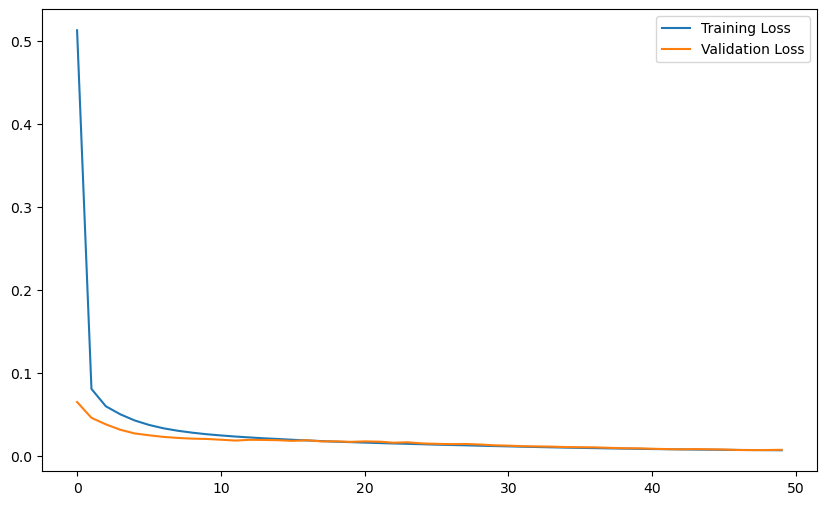

In [33]:
# Plotting the difference between the training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.plot(history.history["loss"], label="Training Loss")
# 
ax.plot(history.history["val_loss"], label="Validation Loss")
# 
ax.legend();

## Anomaly detection 

We will detect anomalies by determining how well our model can reconstruct the input data. First, we find MAE loss on the training samples. MAE, or Mean Absolute Error Loss, is an appropriate loss function for cases where there may be outliers as it can deal with this robustly. The MAE is calculated as the average of the absolute difference between the actual and predicted values.

Next, we want to find the max MAE loss value. This is the worst the model has performed trying to reconstruct a sample, and this will become the threshold for anomaly detection.
If the reconstruction loss for a sample is greater than this threshold value, then we can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an anomaly.[1]


[1]: https://serokell.io/blog/anomaly-detection-in-machine-learning


In [34]:
# model.predict() – A model can be created and fitted with trained data, and used to make a prediction

x_train_pred = model.predict(x_train)


118/118 [==============================] - 1s 10ms/step


In [35]:
# Calculate loss using numpy
# This takes the mean of the absolute value difference between the predicted values and the training values
# https://numpy.org/doc/stable/reference/generated/numpy.absolute.html
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)


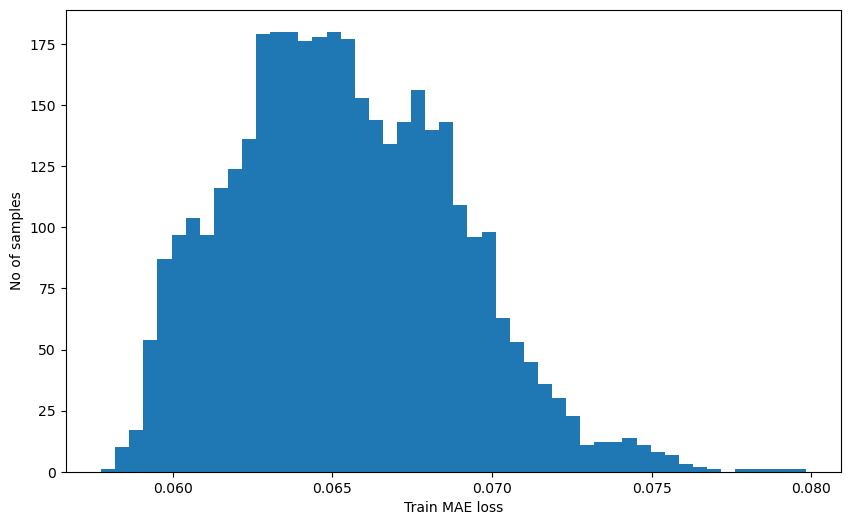

In [36]:
# plot the loss using a histogram 
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(train_mae_loss, bins=50)

# Set labels 
ax.set_xlabel("Train MAE loss")
ax.set_ylabel("No of samples");

In [37]:
# Get reconstruction loss threshold as detailed above
threshold = np.max(train_mae_loss)

print("Reconstruction error threshold: ", threshold)


Reconstruction error threshold:  0.07981867251579063


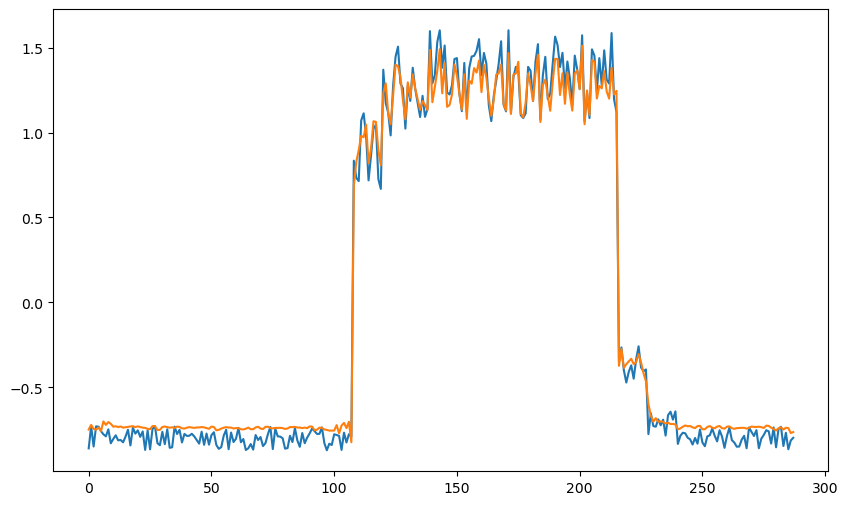

In [38]:
## Checking how the first sequence is learnt
# This is 288 timestamps from day 1 of the dataset
# Set the plot size 
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the training data
ax.plot(x_train[0])

# Plot the predicted data
ax.plot(x_train_pred[0]);


## Prepare test data

We have now trained the model; we must prepare the testing data. Data preparation consists of several steps, which consume more time than other aspects of machine learning application development. A 2021 study by data science platform vendor Anaconda found that data scientists spend an average of 22% of their time on data preparation, which is more than the average time spent on other tasks like deploying models, model training and creating data visualizations. [1]

This testing data is unseen data, and it is used to evaluate the performance and progress of your algorithms’ training and adjust or optimize it for improved results. 

Testing data has two main criteria. It should:

- Represent the actual dataset 
- Be large enough to generate meaningful predictions


Test data provides a final, real-world check of an unseen dataset to confirm that the machine learning algorithm was trained effectively. [2]


The data from the ```with_anomaly``` dataset is now prepared to be used. This entails using this dataset, subtracting the mean from the training set, and dividing this by the training standard deviation.

This is then plotted to compare it to the original data that was fed in. Any discrepancies could mean that the formula used to standardize the data is incorrect. 


[1]: https://www.techtarget.com/searchbusinessanalytics/feature/Data-preparation-in-machine-learning-6-key-steps 
[2]: https://www.obviously.ai/post/the-difference-between-training-data-vs-test-data-in-machine-learning

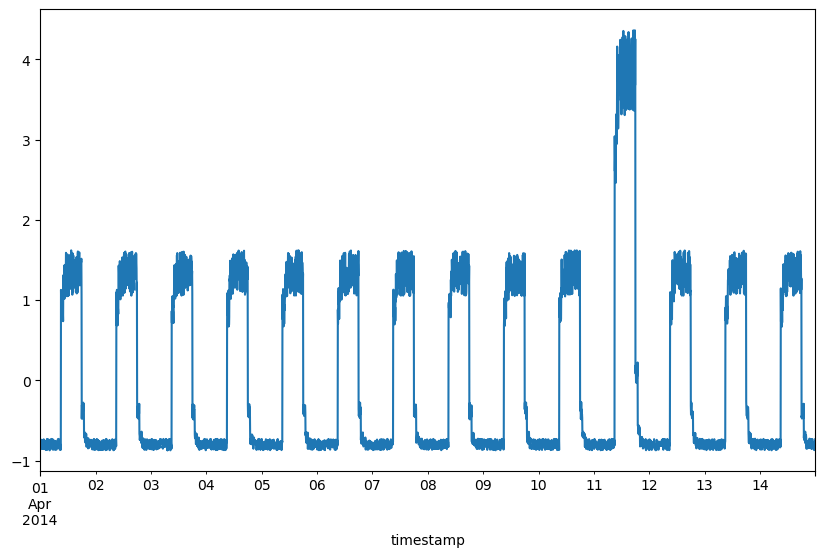

In [39]:
# Creating the test data
df_test_value = (with_anomaly- training_mean) / training_std
# setting the plot characteristics
fig, ax = plt.subplots(figsize=(10, 6))

# plot the data
df_test_value.plot(legend=False, ax=ax);


In [40]:
# Create sequences from test values.
# This is using the windowing function that was described for the training data above
x_test = windows(df_test_value.values)

x_test.shape



(3745, 288, 1)

In [41]:
# # Get test MAE loss.
# This is the exact same procedure used with the training data above 
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))
test_mae_loss




118/118 [==============================] - 1s 10ms/step


array([0.0648094 , 0.06569469, 0.06472674, ..., 0.0656369 , 0.06686061,
       0.06496612])

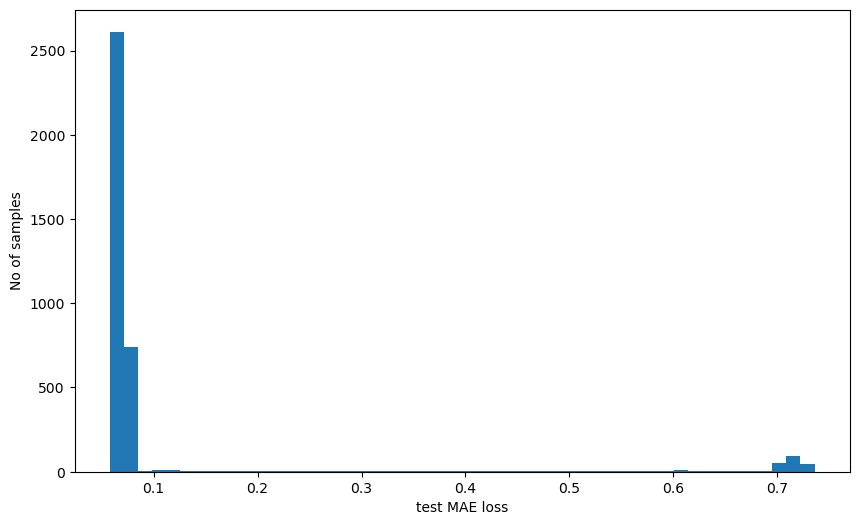

In [42]:
# Plotting the MAE loss as a histogram
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(test_mae_loss, bins=50)

# Setting labels on the axes
ax.set_xlabel("test MAE loss")
ax.set_ylabel("No of samples");

In [43]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

# Number of anomalies.
np.sum(anomalies)

406

## Anomaly Plotting 


Anomaly (or outlier) detection is the data-driven task of identifying these rare occurrences and filtering them from the analysis. Such anomalous events can be connected to some fault in the data source, such as financial fraud, equipment fault, or irregularities in time series analysis. These anomalous data points can later be either flagged to analyze from a business perspective or removed to maintain the cleanliness of the data before further processing is done. [1]


From using MAE above, we know the samples of the data which are anomalies. With this, we will find the corresponding timestamps from the original test data. The following method will be used to do that:

Let's say time_steps = 3 and we have 10 training values. Our x_train will look like this:
```
0, 1, 2
1, 2, 3
2, 3, 4
3, 4, 5
4, 5, 6
5, 6, 7
6, 7, 8
7, 8, 9
```

All except the initial and the final time_steps-1 data values, will appear in time_steps number of samples. So, if we know that the samples [(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point 5 is an anomaly.


[1]: https://www.projectpro.io/article/anomaly-detection-using-machine-learning-in-python-with-example/555

In [44]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies

inds = []

for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)

In [45]:
# creating a subset of the dataframe with the anomalous data
df_subset = with_anomaly.iloc[inds]


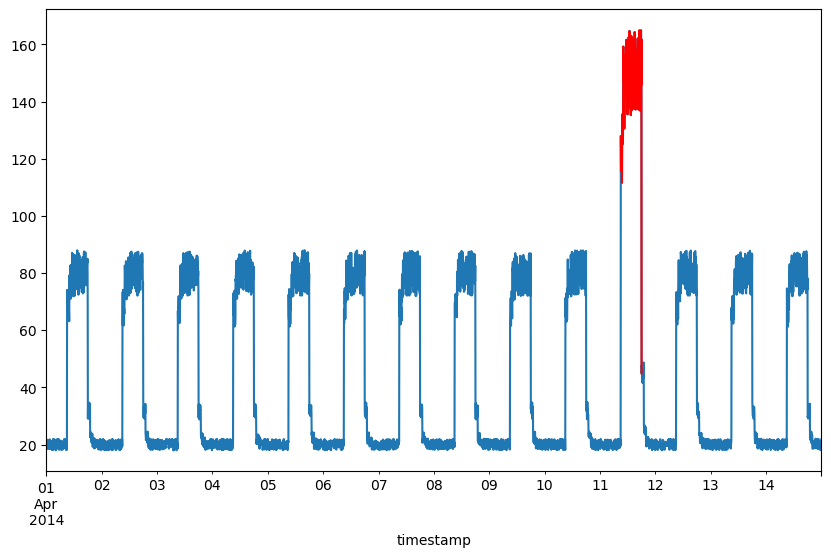

In [46]:
# Plotting this anomalous data 
fig, ax = plt.subplots(figsize=(10, 6))

# The testing data
with_anomaly.plot(legend=False, ax=ax)

# The anomaly detected in the model 
df_subset.plot(legend=False, ax=ax, color="r");

## Conclusion

Through my research in this area, it came to my attention that the strides in the convolution layer have a normal length of one so would be interested to see what difference that would make to the data as it passed through the model layers.[1]
 Running the data on a different dataset with not such an obvious anomaly would be extremely interesting as I would like to see how accurate the network is with less noise. 
 
 
I found this project very interesting, however the Keras website was particularly challenging to use, and I relied a lot on external sources to gather the knowledge and understanding to write this. An easier and more straightforward set of documentation would allow a proper appreciation of the complex methods and arguments that can be used. 


[1]: https://www.jeremyjordan.me/convolutional-neural-networks



# References: 

https://keras.io/examples/timeseries/timeseries_anomaly_detection/ 

  

https://www.kaggle.com/datasets/boltzmannbrain/nab?resource=download 

  

https://towardsdatascience.com/anomaly-detection-using-autoencoders-5b032178a1ea 

  

https://www.statology.org/high-dimensional-data/ 

  

https://stats.stackexchange.com/questions/262044/what-does-a-bottleneck-layer-mean-in-neural-networks 

  

https://stackoverflow.com/questions/44334348/low-and-high-dimensional-data 

  

https://www.baeldung.com/cs/dl-latent-space


https://github.com/numenta/NAB 

 

https://learn.g2.com/training-data 

 

https://academy.rapidminer.com/learn/video/using-windowing-on-time-series-data 

 

https://numpy.org/doc/stable/reference/generated/numpy.stack.html 

https://www.w3resource.com/numpy/manipulation/ndarray-flatten.php 

https://www.tutorialspoint.com/keras/keras_layers.htm 

https://www.analyticsvidhya.com/blog/2022/01/complete-guide-to-anomaly-detection-with-autoencoders-using-tensorflow/ 

https://stackoverflow.com/questions/69591717/how-is-the-keras-conv1d-input-specified-i-seem-to-be-lacking-a-dimension 

https://keras.io/api/layers/regularization_layers/dropout/ 

  

https://www.geeksforgeeks.org/python-tensorflow-tf-keras-layers-conv1dtranspose-function/ 

 

https://keras.io/api/models/sequential/ 

 

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam 

  

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ 

 

https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3 

https://scipy-lectures.org/packages/scikit-learn/index.html 

  

https://keras.io/api/models/model_training_apis/ 

  

https://keras.io/api/callbacks/early_stopping/ 

  

https://datascience.stackexchange.com/questions/73726/keras-early-stopping-monitor-loss-or-val-loss 

https://numpy.org/doc/stable/reference/generated/numpy.absolute.html 

 

https://www.techtarget.com/searchbusinessanalytics/feature/Data-preparation-in-machine-learning-6-key-steps 

 

https://www.obviously.ai/post/the-difference-between-training-data-vs-test-data-in-machine-learning 

https://www.projectpro.io/article/anomaly-detection-using-machine-learning-in-python-with-example/555 

 

https://math.stackexchange.com/questions/317114/what-is-the-purpose-of-subtracting-the-mean-from-data-when-standardizing 

 

https://www.projectpro.io/recipes/what-is-sequential-modelling-keras 

https://keras.io/guides/sequential_model/ 

 

https://www.analyticsvidhya.com/blog/2022/06/understanding-loss-function-in-deep-learning/ 

 

https://serokell.io/blog/anomaly-detection-in-machine-learning 

 

https://keras.io/api/layers/convolution_layers/convolution1d/ 

 

https://mathworld.wolfram.com/Convolution.html 

 

https://stackoverflow.com/questions/48618879/whats-the-dimensionality-of-the-output-space-in-tensorflows-docs 

 

https://www.jeremyjordan.me/convolutional-neural-networks/ 

 

https://keras.io/api/layers/activation_layers/relu/ 

 

https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/ 

 

https://www.educba.com/keras-input/ 

 

https://www.geeksforgeeks.org/python-tensorflow-tf-keras-layers-conv1dtranspose-function/ 

 

https://en.wikipedia.org/wiki/Deconvolution 

